<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Multinomial Logistic Regression Lab

---

## Introduction

In this lab you will practice performing multinomial logistic regression while also applying cross-validation and regularisation on a popular sample dataset about bikesharing. You'll be predicting the season according to the given weather data.

---

## Aim

1. Structure a new dataframe with features, create dummy features with pd.get_dummies(), and join dummies to the data frame
2. Use the bikeshare dataset to create cross-validated multinomial logistic regression models.
3. Build 3 different models: default logistic regression, logistic regression with l1-penalty, and logistic regression with l2-penalty. Report on the accuracy reached in each case.

--- 
## Additional Resources

- [The bikeshare dataset](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#)
- [Cross-validation with sklearn](http://scikit-learn.org/stable/modules/cross_validation.html)
- [Logistic regression with sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
 
---

## 1. Load the libraries and the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
 
sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score

In [3]:
path = '../../../../resource-datasets/bikeshare/bikeshare.csv'
bikeshare = pd.read_csv(path)

In [4]:
bikeshare.shape

(17379, 17)

In [5]:
bikeshare.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

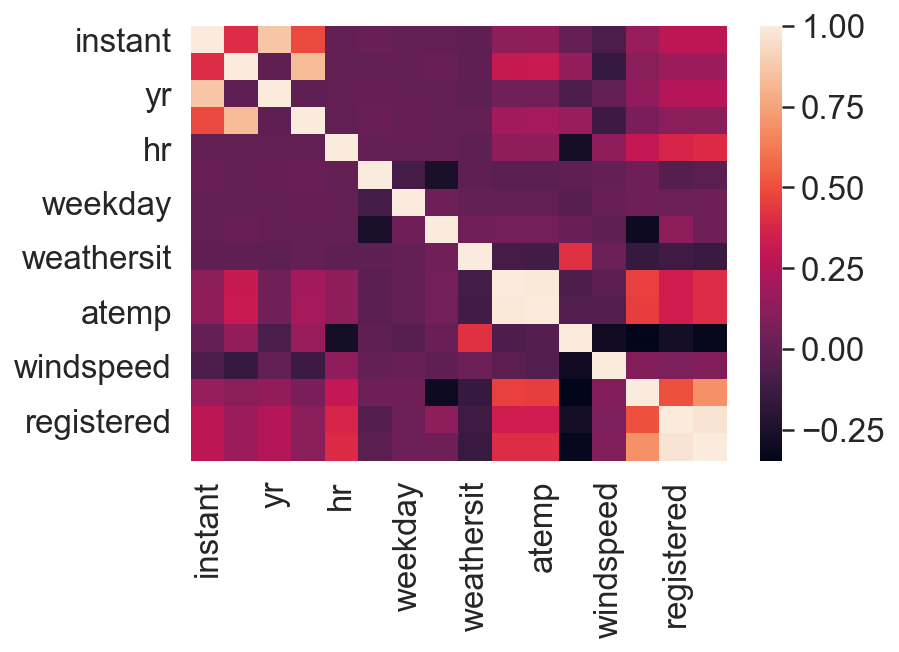

In [6]:
sns.heatmap(bikeshare.corr())
plt.ylim([bikeshare.shape[1]-1, 0])
plt.show()

In [7]:
bikeshare.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


In [8]:
bikeshare.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [9]:
bikeshare.season.value_counts()

3    4496
2    4409
1    4242
4    4232
Name: season, dtype: int64

In [10]:
seasons = bikeshare.season.unique()

In [11]:
bikeshare.weathersit.unique()

array([1, 2, 3, 4])

In [12]:
weather = pd.get_dummies(bikeshare.weathersit, prefix='weather',drop_first=True)
weather.head()

,weather_2,weather_3,weather_4
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


### 2. Join the bikeshare dataframe and the weather dataframe

In [13]:
df = pd.concat([bikeshare,weather],axis=1)
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,weather_2,weather_3,weather_4
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,0,0,0
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,0,0,0
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,0,0,0
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,0,0,0
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,0,0,0


### 3. Choose the weatherrelated features as predictors and the season as response

In [14]:
X = df[['temp','hum','windspeed','weather_2','weather_3','weather_4']]
y = df[['season']]

### 4. Perform a train-test split

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1)

### 5. Rescale the data set.

Use the standard scaler with `fit_transform` on the training set and with transform on the `test set`. Why would you consider doing it in this way?

In [17]:
from sklearn.preprocessing import StandardScaler

In [18]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns,index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns,index=X_test.index)

### 6. Fit a logistic regression model on the training set. Evaluate it and get the predictions on the test set.

In [19]:
logistic = LogisticRegression(C=10**10,solver='lbfgs',max_iter=10000)
logistic.fit(X_train,y_train)

print('Training Score:',logistic.score(X_train,y_train))
print('Test Score:',logistic.score(X_test,y_test))

Training Score: 0.5798029202330433
Test Score: 0.5888952819332566


/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [20]:
predictions = logistic.predict(X_test)
predictions

array([4, 4, 1, ..., 4, 3, 1])

### 7. Report the accuracy, the confusion matrix and the classification report on the test set

In [21]:
print('Accuracy:',logistic.score(X_test,y_test))
print('Accuracy:',metrics.accuracy_score(y_test,predictions))

Accuracy: 0.5888952819332566


NameError: name 'metrics' is not defined

In [22]:
confusion_matrix(y_test,predictions,labels=[1,2,3,4])

array([[663,  52,  10, 105],
       [163, 270, 292, 170],
       [  0,  71, 839,  18],
       [308, 170,  70, 275]])

In [88]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           1       0.58      0.80      0.68       830
           2       0.48      0.30      0.37       895
           3       0.69      0.90      0.78       928
           4       0.48      0.33      0.40       823

    accuracy                           0.59      3476
   macro avg       0.56      0.58      0.56      3476
weighted avg       0.56      0.59      0.56      3476



### 8. Use LogisticRegressionCV to fit a range of l1 penalty values to the training set. 

Hint: l1-penalty requires setting the solver to liblinear.

In [26]:
lasso_cv = LogisticRegressionCV(Cs=50,penalty='l1',solver='liblinear',multi_class='ovr',cv=5)
lasso_cv.fit(X_train,y_train)

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: 

LogisticRegressionCV(Cs=50, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='ovr', n_jobs=None, penalty='l1',
                     random_state=None, refit=True, scoring=None,
                     solver='liblinear', tol=0.0001, verbose=0)

In [30]:
lasso_cv.scores_

{1: array([[0.75449317, 0.75449317, 0.75449317, 0.75449317, 0.82063264,
         0.82063264, 0.82063264, 0.82063264, 0.82602444, 0.83285406,
         0.82961898, 0.82997843, 0.83141625, 0.83357297, 0.83501078,
         0.83537024, 0.83680805, 0.83572969, 0.8364486 , 0.83680805,
         0.83716751, 0.83716751, 0.83716751, 0.83752696, 0.83788641,
         0.83788641, 0.83788641, 0.83788641, 0.83788641, 0.83788641,
         0.83788641, 0.83788641, 0.83788641, 0.83716751, 0.83788641,
         0.83788641, 0.83788641, 0.83788641, 0.83716751, 0.83788641,
         0.83788641, 0.83788641, 0.83788641, 0.83788641, 0.83788641,
         0.83788641, 0.83788641, 0.83788641, 0.83788641, 0.83788641],
        [0.75449317, 0.75449317, 0.75449317, 0.75449317, 0.83105679,
         0.83321352, 0.83321352, 0.83321352, 0.84040259, 0.84219986,
         0.84076204, 0.84291876, 0.84076204, 0.84004313, 0.83860532,
         0.83896477, 0.83824587, 0.83824587, 0.83896477, 0.83896477,
         0.83932423, 0.8386053

In [87]:
lasso_cv.C_

array([6.86648845e+03, 1.00000000e-04, 1.93069773e-02, 1.00000000e-04])

### 9. Use LogisticRegressionCV to fit a range of l2 penalty values to the training set. 

In [47]:
ridge_cv = LogisticRegressionCV(Cs=50,penalty='l2', multi_class='ovr', cv=5)
ridge_cv.fit(X_train,y_train)

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegressionCV(Cs=50, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='ovr', n_jobs=None, penalty='l2',
                     random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [48]:
ridge_cv.C_

array([6.25055193e-03, 1.00000000e-04, 7.90604321e+00, 1.00000000e-04])

In [49]:
ridge_cv.scores_

{1: array([[0.75449317, 0.75449317, 0.75521208, 0.76491733, 0.78181165,
         0.80265996, 0.81595974, 0.83105679, 0.8364486 , 0.83680805,
         0.84076204, 0.84255931, 0.83860532, 0.83824587, 0.83608914,
         0.83608914, 0.83860532, 0.83788641, 0.83752696, 0.83716751,
         0.83716751, 0.83716751, 0.83716751, 0.83752696, 0.83752696,
         0.83752696, 0.83788641, 0.83788641, 0.83788641, 0.83788641,
         0.83788641, 0.83788641, 0.83788641, 0.83788641, 0.83788641,
         0.83788641, 0.83788641, 0.83788641, 0.83788641, 0.83788641,
         0.83788641, 0.83788641, 0.83788641, 0.83788641, 0.83788641,
         0.83788641, 0.83788641, 0.83788641, 0.83788641, 0.83788641],
        [0.75449317, 0.75449317, 0.75521208, 0.76383896, 0.78432782,
         0.80877067, 0.82854062, 0.83465133, 0.83213515, 0.83896477,
         0.84076204, 0.8418404 , 0.83968368, 0.84148095, 0.84076204,
         0.8411215 , 0.84004313, 0.83968368, 0.84004313, 0.84040259,
         0.84004313, 0.8396836

In [50]:
ridge_cv.score(X_test,y_test)

0.5747986191024166

### 10. Obtain the confusion matrices for the predictions on the test set obtained with the l1 and l2 regularized models. Compare and explain your findings.

In [85]:
confusion_matrix(y_test,lasso_cv.predict(X_test),labels=[1,2,3,4])

array([[556, 274,   0,   0],
       [ 73, 642, 180,   0],
       [  0, 210, 718,   0],
       [181, 601,  41,   0]])

In [86]:
confusion_matrix(y_test,ridge_cv.predict(X_test),labels=[1,2,3,4])

array([[709,  48,  10,  63],
       [195, 241, 322, 137],
       [  0,  62, 850,  16],
       [382, 164,  79, 198]])

### 11. Plot the accuracy obtained on the training set versus the penalty strength for both, l1 and l2.

In [56]:
lasso = {}
for key in lasso_cv.scores_.keys():
    lasso[key] = []
    for c in range(50):
        lasso[key].append(np.mean(lasso_cv.scores_[key][:,c]))
        
ridge = {}
for key in ridge_cv.scores_.keys():
    ridge[key] = []
    for c in range(50):
        ridge[key].append(np.mean(ridge_cv.scores_[key][:,c]))

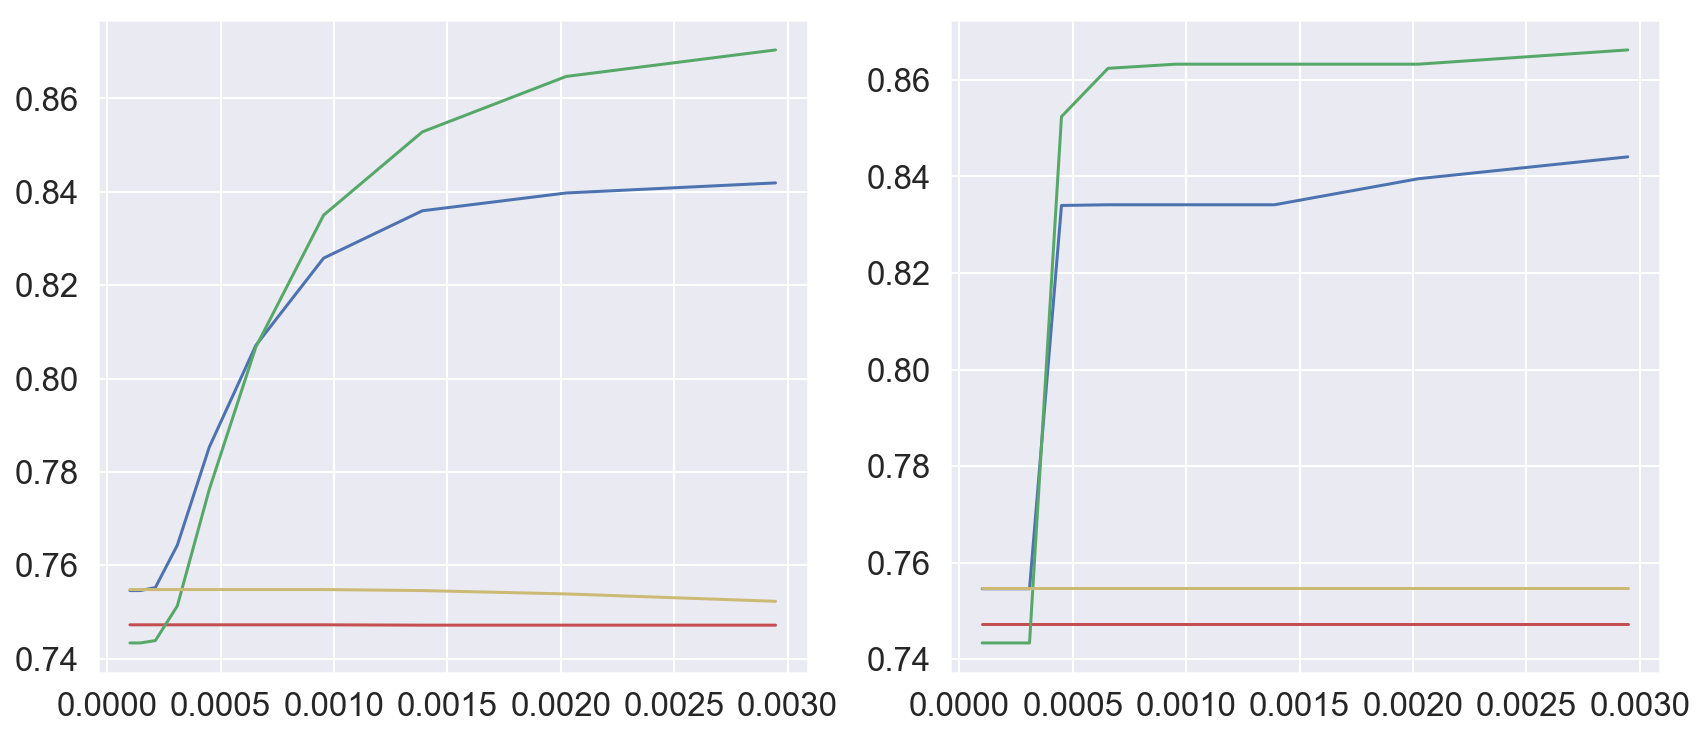

In [84]:
fig, ax = plt.subplots(ncols=2, figsize=(14,6))
sns.lineplot(x=ridge_cv.Cs_[:-40], y=ridge[1][:-40], c='b', ax=ax[0])
sns.lineplot(x=ridge_cv.Cs_[:-40], y=ridge[2][:-40], c='r', ax=ax[0])
sns.lineplot(x=ridge_cv.Cs_[:-40], y=ridge[3][:-40], c='g', ax=ax[0])
sns.lineplot(x=ridge_cv.Cs_[:-40], y=ridge[4][:-40], c='y', ax=ax[0])

sns.lineplot(x=lasso_cv.Cs_[:-40], y=lasso[1][:-40], c='b', ax=ax[1])
sns.lineplot(x=lasso_cv.Cs_[:-40], y=lasso[2][:-40], c='r', ax=ax[1])
sns.lineplot(x=lasso_cv.Cs_[:-40], y=lasso[3][:-40], c='g', ax=ax[1])
sns.lineplot(x=lasso_cv.Cs_[:-40], y=lasso[4][:-40], c='y', ax=ax[1])

### 12. Bonus: Create a ROC curve and a precision-recall curve for the best l1 and l2 models

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn import metrics